# recurrent neural network (RNN)

- input data is fixed-size segments : eith kmer-expand or shrink-expand is not good. validation failed
- input data is sliced by 2 AA: failed.

In [1]:
import json
import os
from copy import deepcopy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import torch
import torch.nn as nn

2024-11-29 18:06:48.842209: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-29 18:06:48.849668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 18:06:48.858058: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-29 18:06:48.860518: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 18:06:48.867177: I tensorflow/core/platform/cpu_feature_guar

In [2]:
%load_ext autoreload
%autoreload 2
    
torch.manual_seed(1)

In [3]:
device = ("cuda" if torch.cuda.is_available() else "mps"
    if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


## dataset

In [29]:
# failed
# outdir = '/home/yuan/results/epitope/seq'
# df1 = pd.read_csv('/home/yuan/results/epitope/seq/epitope_50_shrink_expand.txt', sep='\t', header=None, index_col=None)
# df2 = pd.read_csv('/home/yuan/results/epitope/seq/other_50.txt', sep='\t', header=None, index_col=None)
# df3 = pd.read_csv('/home/yuan/results/epitope/seq/random_50.txt', sep='\t', header=None, index_col=None)
# df = pd.concat([df1, df2, df3])
# df = df.sample(frac=1)

In [34]:
df1 = pd.read_csv('/home/yuan/results/epitope/epitope.txt', sep='\t', header=None, index_col=None)
df2 = pd.read_csv('/home/yuan/results/epitope/other.txt', sep='\t', header=None, index_col=None)
df3 = pd.read_csv('/home/yuan/results/epitope/random.txt', sep='\t', header=None, index_col=None)
df = pd.concat([df1, df2, df3])
df = df.sample(frac=1)

In [35]:
print(df.shape, df1.shape, df2.shape)
df.head()

(14694342, 2) (3552504, 2) (7590778, 2)


,0,1
7352937,YFSDRKNNYV,other
3337599,DHEISVQKKINR,epitope
2261485,VCSAVYIQVGL,random
2483944,SSGNIGMALP,other
1855463,EVAFLPSEHYRNHSINFG,random


In [31]:
from collections import Counter

train_data = list(df.iloc[:100_000,:].apply(lambda x: (x[1], x[0]), axis=1))
# train_data = list(df.apply(lambda x: (x[1], x[0]), axis=1))
print(train_data[0])
counts = Counter([i[0] for i in train_data])
print(counts)

('random', 'HRPALFAVRWRGDHHAMILVDCYNYVYYLAEDMVGGVWWWEPDFNKIVTA')
Counter({'random': 49157, 'other': 27930, 'epitope': 22913})


In [41]:
# embedding
from my_embedding import MyEmbedding

me = MyEmbedding(train_data)
train_ds, valid_ds, test_ds = me.split()
me.tokenize(k=2)
input_vocab, label_vocab = me.build_vocab()

('random', 'NARELKFAQTFEPPSWVWYIMKWRRCLMQVTSQCEYKALDIYPFRSWAWS')
60000 20000 20000

## Step 2 tokenization: unique tokens (words)...
A sentence converted to tokens: CEFAYLRDLLIRTHMQNIKDITSSIHFEAYRVKRLNEGSSAMANGMEEKE ['CE', 'FA', 'YL', 'RD', 'LL', 'IR', 'TH', 'MQ', 'NI', 'KD', 'IT', 'SS', 'IH', 'FE', 'AY', 'RV', 'KR', 'LN', 'EG', 'SS', 'AM', 'AN', 'GM', 'EE', 'KE']
Vocab-size of input: 433
Vocab-size of labels: 3
OrderedDict([('LL', 9574), ('AA', 8034), ('SS', 7888), ('AL', 7512), ('EE', 7501), ('SL', 7476), ('LS', 7436), ('LA', 7243), ('LE', 7024), ('VL', 6798), ('LK', 6384), ('EL', 6355), ('GG', 6309), ('GL', 6295), ('LR', 6244), ('LV', 6208), ('LG', 6173), ('SG', 6169), ('AS', 6137), ('GS', 6096), ('LP', 6050), ('LT', 5976), ('SA', 5966), ('AV', 5925), ('EA', 5898), ('AG', 5873), ('TL', 5873), ('LQ', 5872), ('KL', 5861), ('AE', 5772), ('DL', 5706), ('EK', 5697), ('PP', 5678), ('RL', 5670), ('KE', 5658), ('VA', 5642), ('VS', 5628), ('SV', 5588), ('GA', 5550), ('PL', 5549), ('LD', 5520

In [42]:
from my_dataset import MyDataset
from my_collate import MyCollate
from my_rnn import MyRNN
from my_process import MyProcess

vocab_size = len(input_vocab)
embedding_dim = 48
model = MyRNN(vocab_size, embedding_dim).to(device)
print(model)

# training model
# update collate_batch
## Step 3-A: define the functions for transformation
# feed a tokens vector representing one sentence 
text_pipeline = lambda x: [input_vocab[token] for token in list(x)]
label_pipeline = lambda x: 1 if x == 'epitope' else 0
collate_fn = MyCollate(text_pipeline, label_pipeline)

num_epochs = 10
p = MyProcess(model, collate_fn, num_epochs)
trained_model, stat = p.run(train_ds, valid_ds)

MyRNN(
  (embedding): Embedding(435, 48, padding_idx=0)
  (rnn): LSTM(48, 64, num_layers=2, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
Epoch 0 acc: 0.7708 val_acc: 0.7732, val_recall: 0.5000
Epoch 1 acc: 0.7708 val_acc: 0.7732, val_recall: 0.5000
Epoch 2 acc: 0.7708 val_acc: 0.7732, val_recall: 0.5000
Epoch 3 acc: 0.7708 val_acc: 0.7732, val_recall: 0.5000
Epoch 4 acc: 0.7708 val_acc: 0.7732, val_recall: 0.5000
Epoch 5 acc: 0.7708 val_acc: 0.7732, val_recall: 0.5000
Epoch 6 acc: 0.7708 val_acc: 0.7732, val_recall: 0.5000
Epoch 7 acc: 0.7708 val_acc: 0.7732, val_recall: 0.5000
Epoch 8 acc: 0.7708 val_acc: 0.7732, val_recall: 0.5000
Epoch 9 acc: 0.7708 val_acc: 0.7732, val_recall: 0.5000


In [17]:
# test predict
input = [
    # epitope
    'SSPFLKGFLAGYVVAKLRASAV', 
    # other seq
    'AELMPVGDNN',
    # wrong seq
    'AXAXAXAXA'
]
res = p.predict(input)
res

,text,predict
0,SSPFLKGFLAGYVVAKLRASAV,0.993739
1,AELMPVGDNN,0.000020
2,AXAXAXAXA,1.000000


In [18]:
print(trained_model.embedding)
print(trained_model.embedding.weight.shape)

Embedding(23, 32, padding_idx=0)
torch.Size([23, 32])


In [19]:
stat

,acc_train,loss_train,acc_valid,loss_valid,rec_valid
0,0.935380,0.151756,0.939248,0.144231,0.913636
1,0.940695,0.140580,0.941248,0.139232,0.921152
2,0.942171,0.137967,0.942046,0.138325,0.919056
3,0.943017,0.136287,0.942407,0.137763,0.925505
4,0.943588,0.135903,0.942590,0.137975,0.924493
5,0.943886,0.137155,0.942880,0.137175,0.923897
6,0.944115,0.137858,0.942759,0.138235,0.925358
7,0.944253,0.134852,0.942825,0.139870,0.923414
8,0.944107,0.136594,0.942285,0.140818,0.922118
9,0.942216,0.156194,0.937939,0.167283,0.912332


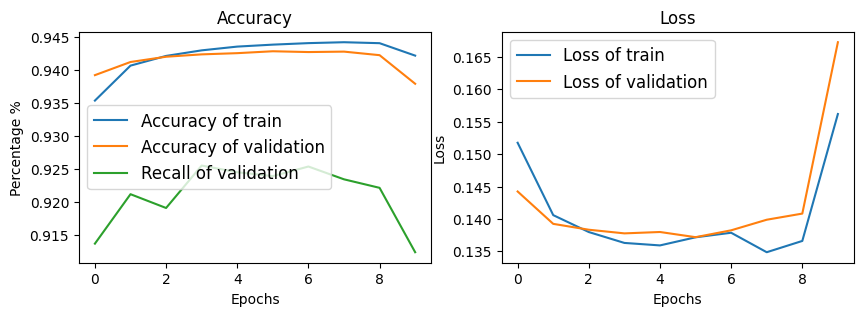

In [20]:
fig = plt.figure(figsize=(10,3))
x_arr = list(range(num_epochs))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, stat.acc_train, label="Accuracy of train")
ax.plot(x_arr, stat.acc_valid, label="Accuracy of validation")
ax.plot(x_arr, stat.rec_valid, label="Recall of validation")
ax.legend(fontsize=12)
# ax.set_ylim(.8, 1)
ax.set_title('Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Percentage %')

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, stat.loss_train, label="Loss of train")
ax.plot(x_arr, stat.loss_valid, label="Loss of validation")
ax.legend(fontsize=12)
ax.set_title('Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

plt.show()

In [21]:
# test model using test data
res = p.test(test_ds)
res

{'recall': 0.9122450916349945,
 'accuracy': 0.9377886527095968,
 'loss': 0.16783918841910653}

In [22]:
# distriubtion of prediction probability using test data
test_X = [i[1] for i in test_ds]
pred_test = p.predict(test_X)
pred_test['labels'] = [i[0] for i in test_ds]
pred_test.head()

,text,predict,labels
0,NELFQPTVSGIIQ,6.709604e-01,epitope
1,LHDLSKAELA,1.372976e-14,other
2,GVPNDKEFETFT,8.560386e-01,random
3,ERPYKCELCP,3.330221e-05,other
4,GGGRGGYGGGGP,9.830779e-01,epitope


711246 2227623


Text(0.5, 1.0, 'Detect none epitope sequences, n = 2227623')

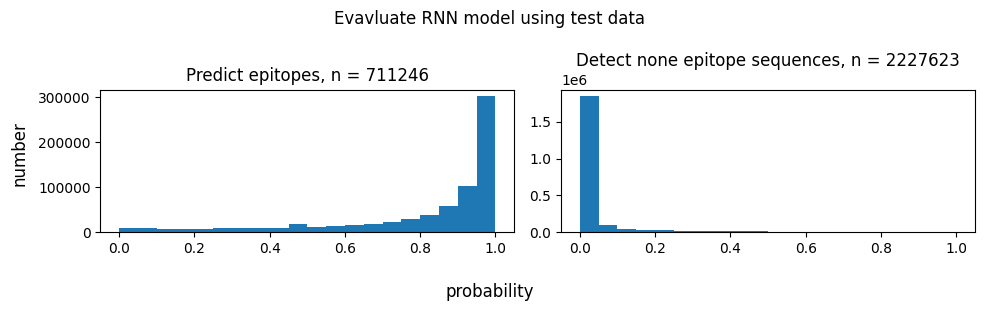

In [28]:
t = pred_test[pred_test['labels']=='epitope']['predict']
f = pred_test[~(pred_test['labels']=='epitope')]['predict']
print(len(t), len(f))

fig, ax = plt.subplots(1, 2, figsize=(10,3), layout='tight')
fig.suptitle('Evavluate RNN model using test data')
fig.supxlabel('probability')
fig.supylabel('number')

ax[0].hist(t, bins=20)
ax[0].set_title(f'Predict epitopes, n = {len(t)}')
ax[1].hist(f, bins=20)
ax[1].set_title(f'Detect none epitope sequences, n = {len(f)}')

In [29]:
# save model
torch.save(input_vocab, '../models/epitopes_rnn_vocab.pth')
torch.save(model.state_dict(), '../models/epitopes_rnn.pth')